In [1]:
import numpy as np
import os
import sys
from simulation import heart_rate
#%matplotlib widget
from matplotlib import pyplot as plt
from scipy import signal as ss
import scipy
from utils.wall_processing import MModeDist
from simulation.utils import periodic_wrap_fn, SPEED_OF_US, demodulate_I_Q
import utils.signal as sp
from utils.us_data import WULPUS_load
from utils.plots import time_plot
%matplotlib widget
import ipywidgets as widgets
plt.style.use('seaborn-whitegrid')
from utils.plots import tinyprobe_visualize
from utils.doppler import DopplerSignal


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


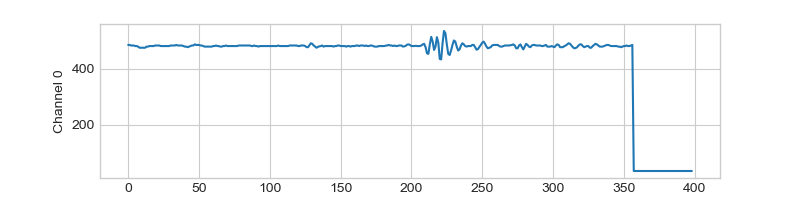

interactive(children=(IntSlider(value=0, description='frame', max=8399), Output()), _dom_classes=('widget-inte…

(399, 8400)

In [2]:
#data, _ = WULPUS_load("Doppler_data/Doppler_4.npz", verbose=True)
def get_raw(file_name):
    data_file = np.load(file_name)
    return data_file

channel = 1
data = get_raw(f"Example_TinyProbe_data4_5.5.2024/1.npy")[:,channel,:].T
#data = get_raw(f"TinyProbe_data3_6.03.2024/2.npy")[:,channel,:].T
fs = 10e6
f_acq = 1.4e3
f_us = 2.25e6
plt.close("all")
tinyprobe_visualize(np.expand_dims(data[:,:].T,axis=1),fs=1e6,FPS=f_acq)
#time_plot(data[:,:], 1)
data.shape

In [3]:
data_filt = sp.butter_bp(data, fc=(1.5e6,2.5e6), fs=fs, axis = 0)
#plt.figure()
#time_plot(data_filt[:,10], 1/fs)

In [4]:
over_sample_factor=10
fos = fs*over_sample_factor
data_os = ss.resample(data_filt, data_filt.shape[0]*over_sample_factor, axis = 0)

In [5]:
v_max = 100
SPEED_OF_US=1800
fd_max = v_max/SPEED_OF_US*f_us/np.cos(np.pi/180*75)
print(fd_max)
v_min = 0.03
fd_min = v_min/SPEED_OF_US*f_us
print(fd_max)
print(fd_min)

I,Q = sp.demodulate_I_Q(data_os,2.25e6+50, lp_cutoff=f_us/2, dt=1/fos, filt_order=2, axis=0)

#plt.close("all")
#plt.figure()
#I=sp.butter_bp(I, (fd_min,fd_max), f_acq, axis=1)
#Q=sp.butter_bp(Q, (fd_min,fd_max), f_acq, axis=1)
"""def plt_IQ(idx=285):
    plt.clf()
    time_plot(I[idx*over_sample_factor,:], 1/f_acq,label='I')
    time_plot(Q[idx*over_sample_factor,:], 1/f_acq, label='Q')
    plt.draw()
    plt.legend()

widgets.interact(plt_IQ, 
                 idx=widgets.IntSlider(min=0, max=500, 
                                         step=1, value=285)
                )  """

482962.91314453416
482962.91314453416
37.5


"def plt_IQ(idx=285):\n    plt.clf()\n    time_plot(I[idx*over_sample_factor,:], 1/f_acq,label='I')\n    time_plot(Q[idx*over_sample_factor,:], 1/f_acq, label='Q')\n    plt.draw()\n    plt.legend()\n\nwidgets.interact(plt_IQ, \n                 idx=widgets.IntSlider(min=0, max=500, \n                                         step=1, value=285)\n                )  "

In [6]:
I_hilbert = ss.hilbert(I,axis=0)
Q_hilbert = ss.hilbert(Q,axis=0)
forward = I_hilbert.real+Q_hilbert.imag
backward = Q_hilbert.real+I_hilbert.imag

In [7]:
plt.close("all")
fig, ax1 = plt.subplots(figsize=(7,3))
speeds = np.array([0,50,100])
freqs = speeds/100/SPEED_OF_US*f_us*2*np.cos(np.pi/180*75)
print(freqs)
def plt_spec(idx=285):
    ax1.specgram(I[idx*over_sample_factor,:],Fs=f_acq,NFFT=64,noverlap=63,
                 scale = 'dB',cmap='gist_gray',vmin=-50)
    plt.draw()
    plt.show()
    ax1.set_ylabel("Velocity [cm/s]")
    ax1.set_xlabel("Time [s]")
    ax1.set_yticks(freqs,speeds)
    ax1.grid(False)

widgets.interact(plt_spec, 
                 idx=widgets.IntSlider(min=0, max=500, 
                                         step=1, value=279)
                )     

[  0.         323.52380638 647.04761276]


interactive(children=(IntSlider(value=279, description='idx', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plt_spec(idx=285)>

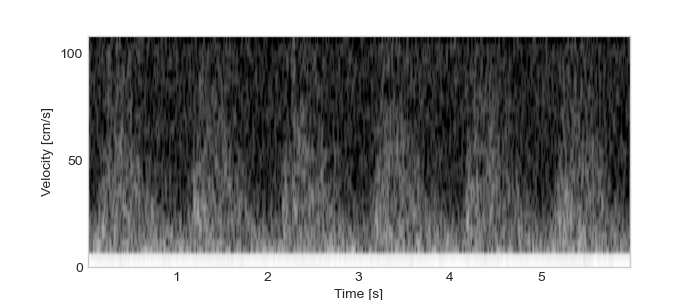

In [8]:
plt_spec(idx=285)
plt.savefig("flow_25cm_s.pdf")

In [9]:
from skimage.color import label2rgb
from skimage.filters import threshold_multiotsu
from skimage import data

image = data.camera()

thresholds = threshold_multiotsu(image,2)

regions = np.digitize(image, bins=thresholds)

regions_colorized = label2rgb(regions)

In [10]:
from skimage.color import label2rgb
from skimage.filters import threshold_multiotsu
idx=250
doppler = I[idx*over_sample_factor,:]+Q[idx*over_sample_factor,:]
freqs, t, Sxx = ss.spectrogram(doppler,fs=1.4e3,window="hann",
                       nperseg=int(1.4e3*50e-3),noverlap=int(1.4e3*50e-3)//2,nfft=512)
velocities = freqs/2.25e6*1800*100
Sxx_db= 10*np.log10(Sxx)
vmax = np.max(Sxx_db)
Sxx_db[Sxx_db < vmax-60] = vmax-60
blured = scipy.ndimage.gaussian_filter(Sxx_db,sigma=1)
threshold = threshold_multiotsu(blured,2)[0]
thresholded = blured > threshold


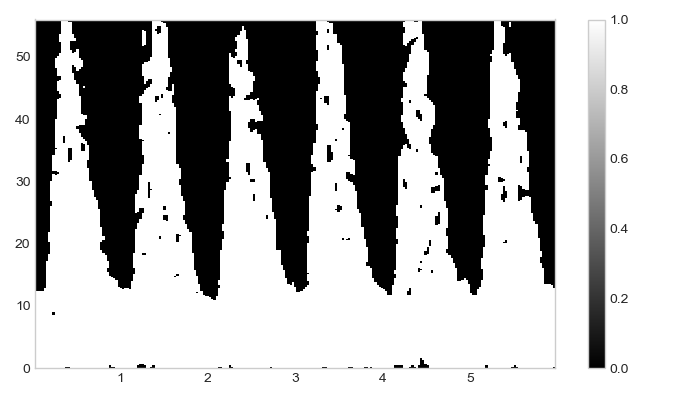

In [11]:
plt.close("all")
fig = plt.figure(figsize=(7,4))
ax = plt.gca()
im = ax.imshow(thresholded,extent=[t.min(), t.max(), velocities.min(), velocities.max()], 
          origin='lower',aspect='auto',cmap="gist_gray",interpolation="none")

plt.grid(False)

fig.colorbar(im)
plt.tight_layout()

In [12]:
from scipy.ndimage import label, find_objects
# Label connected components
labeled_image, num_features = label(thresholded)

# Calculate the area of each component
component_slices = find_objects(labeled_image)
component_areas = [np.sum(labeled_image[sl] == (i + 1)) for i, sl in enumerate(component_slices)]

# Create a copy of the labeled image to remove small components
cleaned_image = labeled_image.copy()

# Remove components with an area less than 300 pixels
area_threshold = 300
for i, area in enumerate(component_areas):
    if area < area_threshold:
        cleaned_image[labeled_image == (i + 1)] = 0

# Convert cleaned image back to binary
cleaned_binary_image = (cleaned_image > 0).astype(np.uint8)

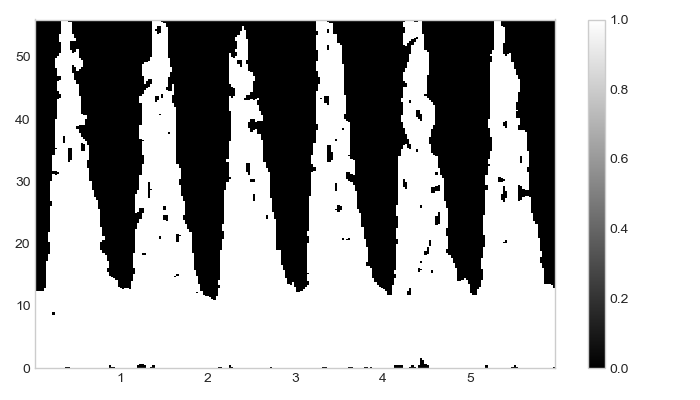

In [13]:
plt.close("all")
fig = plt.figure(figsize=(7,4))
ax = plt.gca()
im = ax.imshow(cleaned_binary_image,extent=[t.min(), t.max(), velocities.min(), velocities.max()], 
          origin='lower',aspect='auto',cmap="gist_gray",interpolation="none")

plt.grid(False)

fig.colorbar(im)
plt.tight_layout()

In [14]:
max_freq = np.zeros(cleaned_binary_image.shape[1])
max_speed = np.zeros(cleaned_binary_image.shape[1])
for col in range(cleaned_binary_image.shape[1]):
    column_data = cleaned_binary_image[:, col]
    if np.any(column_data):  # Check if there's any 1 in the column
        idx = np.max(np.where(column_data == 1))
        max_freq[col] = freqs[idx]
        max_speed[col] = velocities[idx]
        
N=5
max_freq= np.convolve(max_freq, np.ones(N)/N, mode='valid')
max_speed= np.convolve(max_speed, np.ones(N)/N, mode='valid')

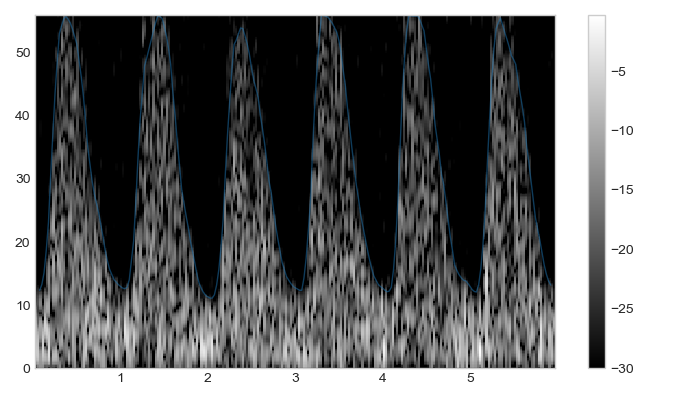

In [15]:
plt.close("all")
fig = plt.figure(figsize=(7,4))
ax = plt.gca()
im = ax.imshow(Sxx_db,extent=[t.min(), t.max(), velocities.min(), velocities.max()], 
          origin='lower',aspect='auto',cmap="gist_gray",interpolation="none",vmin=-30)

plt.grid(False)

ax.plot(t[(N)//2:-(N+1)//2+1],max_speed,linewidth=1,alpha=.5)
fig.colorbar(im)
plt.tight_layout()

In [16]:
with open('doppler_1_250.npy', 'wb') as f:
    np.save(f, np.array(t[(N)//2:-(N+1)//2+1]))
    np.save(f, max_freq)
    np.save(f, t)
    np.save(f, freqs)
    np.save(f, Sxx_db)